In [61]:
# Medicare Healthcare Cost Prediction Analysis
# Complete Jupyter Notebook for predicting healthcare costs using Medicare data

# =============================================================================
# 1. Importing Important Libraries
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [62]:
# =============================================================================
# 2. Data Loading and Initial Exploration
# =============================================================================

# Load the dataset
df = pd.read_csv('/content/Medicare_IP_Hospitals_by_Provider_and_Service_2023.csv', encoding='latin1')

print("Dataset shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

Dataset shape: (146427, 15)

Column names:
['ï»¿Rndrng_Prvdr_CCN', 'Rndrng_Prvdr_Org_Name', 'Rndrng_Prvdr_City', 'Rndrng_Prvdr_St', 'Rndrng_Prvdr_State_FIPS', 'Rndrng_Prvdr_Zip5', 'Rndrng_Prvdr_State_Abrvtn', 'Rndrng_Prvdr_RUCA', 'Rndrng_Prvdr_RUCA_Desc', 'DRG_Cd', 'DRG_Desc', 'Tot_Dschrgs', 'Avg_Submtd_Cvrd_Chrg', 'Avg_Tot_Pymt_Amt', 'Avg_Mdcr_Pymt_Amt']

First few rows:
   ï»¿Rndrng_Prvdr_CCN            Rndrng_Prvdr_Org_Name Rndrng_Prvdr_City  \
0                10001  Southeast Health Medical Center            Dothan   
1                10001  Southeast Health Medical Center            Dothan   
2                10001  Southeast Health Medical Center            Dothan   
3                10001  Southeast Health Medical Center            Dothan   
4                10001  Southeast Health Medical Center            Dothan   

          Rndrng_Prvdr_St  Rndrng_Prvdr_State_FIPS  Rndrng_Prvdr_Zip5  \
0  1108 Ross Clark Circle                        1              36301   
1  1108 Ross Cla

In [63]:
# =============================================================================
# 3. Data Cleaning and Preprocessing
# =============================================================================

# Rename columns for better readability
df = df.rename(columns={
    "ï»¿Rndrng_Prvdr_CCN": "provider_id",
    "Rndrng_Prvdr_Org_Name": "provider_name",
    "Rndrng_Prvdr_City": "city",
    "Rndrng_Prvdr_St": "state",
    "Rndrng_Prvdr_State_FIPS": "state_fips",
    "Rndrng_Prvdr_Zip5": "zip_code",
    "Rndrng_Prvdr_State_Abrvtn": "state_abbr",
    "Rndrng_Prvdr_RUCA": "ruca_code",
    "Rndrng_Prvdr_RUCA_Desc": "ruca_desc",
    "DRG_Cd": "drg_code",
    "DRG_Desc": "drg_desc",
    "Tot_Dschrgs": "total_discharges",
    "Avg_Submtd_Cvrd_Chrg": "avg_submitted_charge",
    "Avg_Tot_Pymt_Amt": "avg_total_payment",
    "Avg_Mdcr_Pymt_Amt": "avg_medicare_payment"
})

print("Columns renamed successfully!")

# Drop unnecessary columns
df = df.drop(['provider_id', 'provider_name', 'state_fips', 'zip_code', 'state', 'ruca_desc', 'city', 'drg_code'], axis=1)

print("Unnecessary columns dropped. New shape:", df.shape)

# Clean monetary columns (remove $ and , symbols)
money_columns = ['avg_submitted_charge', 'avg_medicare_payment', 'avg_total_payment']

for col in money_columns:
    df[col] = df[col].replace({'\\$': '', ',': ''}, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Clean and convert the total_discharges column
df['total_discharges'] = df['total_discharges'].replace({',': ''}, regex=True)
df['total_discharges'] = pd.to_numeric(df['total_discharges'], errors='coerce')

# Fill missing values in ruca_code with mean
mean_ruca = df['ruca_code'].mean()
df['ruca_code'] = df['ruca_code'].fillna(mean_ruca)

# Drop additional columns to focus on key features
df = df.drop(['avg_submitted_charge', 'avg_medicare_payment'], axis=1)

# Clean column names (replace spaces with underscores)
df.columns = df.columns.str.replace(" ", "_")

print("Data cleaning completed!")
print("Final dataset info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())


Columns renamed successfully!
Unnecessary columns dropped. New shape: (146427, 7)
Data cleaning completed!
Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146427 entries, 0 to 146426
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   state_abbr         146427 non-null  object 
 1   ruca_code          146427 non-null  float64
 2   drg_desc           146427 non-null  object 
 3   total_discharges   146427 non-null  int64  
 4   avg_total_payment  146427 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 5.6+ MB
None

Missing values:
state_abbr           0
ruca_code            0
drg_desc             0
total_discharges     0
avg_total_payment    0
dtype: int64


Dataset Statistics:
           ruca_code  total_discharges  avg_total_payment
count  146427.000000     146427.000000      146427.000000
mean        1.751225         33.875754       18512.963019
std         6.222555         49.814354       21313.196905
min         1.000000         11.000000        1938.430000
25%         1.000000         14.000000        8685.925000
50%         1.000000         20.000000       12830.710000
75%         1.000000         35.000000       20403.215000
max        99.000000       3210.000000      761738.780000


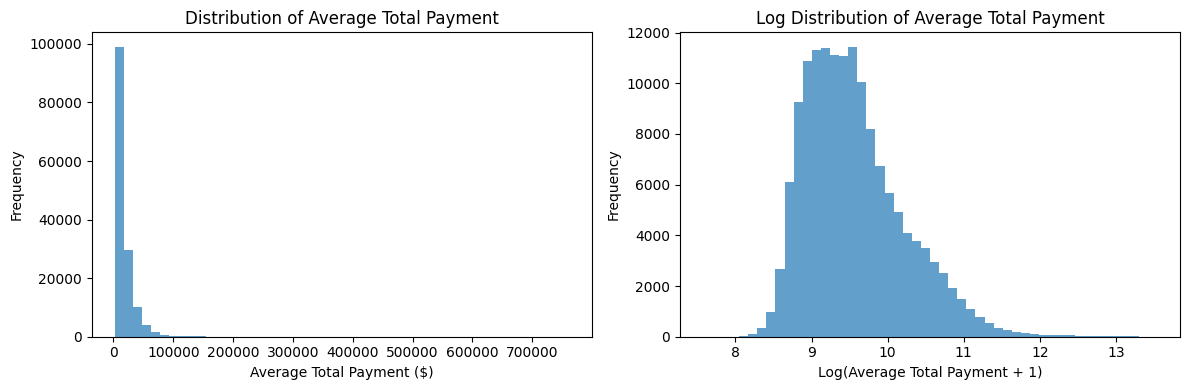


Top 10 most common procedures:
drg_desc
SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOURS WITH MCC                         2678
HEART FAILURE AND SHOCK WITH MCC                                                  2633
RESPIRATORY INFECTIONS AND INFLAMMATIONS WITH MCC                                 2472
SIMPLE PNEUMONIA AND PLEURISY WITH MCC                                            2412
SEPTICEMIA OR SEVERE SEPSIS WITHOUT MV >96 HOURS WITHOUT MCC                      2228
PULMONARY EDEMA AND RESPIRATORY FAILURE                                           2130
KIDNEY AND URINARY TRACT INFECTIONS WITHOUT MCC                                   2088
RENAL FAILURE WITH CC                                                             1999
ESOPHAGITIS, GASTROENTERITIS AND MISCELLANEOUS DIGESTIVE DISORDERS WITHOUT MCC    1951
RENAL FAILURE WITH MCC                                                            1948
Name: count, dtype: int64


In [64]:
#=============================================================================
# 4. Exploratory Data Analysis
# =============================================================================

# Basic statistics
print("Dataset Statistics:")
print(df.describe())

# Distribution of target variable
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['avg_total_payment'], bins=50, alpha=0.7)
plt.title('Distribution of Average Total Payment')
plt.xlabel('Average Total Payment ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(np.log(df['avg_total_payment'] + 1), bins=50, alpha=0.7)
plt.title('Log Distribution of Average Total Payment')
plt.xlabel('Log(Average Total Payment + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Top DRG descriptions by frequency
print("\nTop 10 most common procedures:")
print(df['drg_desc'].value_counts().head(10))

In [65]:
# =============================================================================
# 5. Feature Engineering
# =============================================================================

def categorize_procedure(drg_desc):
    """
    Categorizes a medical procedure based on keywords in its description.
    """
    # Convert to lowercase for easier matching
    drg_desc = str(drg_desc).lower()

    # 1. Major Surgeries / Intensive Care (Highest Cost)
    if 'transplant' in drg_desc or 'ecmo' in drg_desc or 'tracheostomy' in drg_desc:
        return 'Major Surgery/Intensive Care'

    # 2. Cardiology (Heart-related)
    elif 'cardiac' in drg_desc or 'heart' in drg_desc or 'valve' in drg_desc:
        return 'Cardiology'

    # 3. Orthopedics (Bones and Joints)
    elif 'joint' in drg_desc or 'spinal fusion' in drg_desc or 'back & neck' in drg_desc:
        return 'Orthopedics'

    # 4. Neurology (Brain and Nervous System)
    elif 'nervous system' in drg_desc or 'craniotomy' in drg_desc:
        return 'Neurology'

    # 5. Pulmonary (Lungs and Breathing)
    elif 'pulmonary' in drg_desc or 'respiratory' in drg_desc:
        return 'Pulmonary'

    # 6. Septicemia (Major Infections)
    elif 'septicemia' in drg_desc:
        return 'Infections'

    # If none of the above, classify as Other
    else:
        return 'Other'

# Apply the categorization function
df['procedure_category'] = df['drg_desc'].apply(categorize_procedure)

print("Distribution of procedure categories:")
print(df['procedure_category'].value_counts())

# Create interaction features
df['state_procedure_interaction'] = df['state_abbr'] + '_' + df['procedure_category']

# Bin total_discharges into volume categories
df['discharge_volume'] = pd.qcut(df['total_discharges'], q=3, labels=['Low_Volume', 'Medium_Volume', 'High_Volume'])

# Drop the original drg_desc column as it's no longer needed
df = df.drop(['drg_desc'], axis=1)

print("Feature engineering completed!")
print("Final dataset shape:", df.shape)
print(df.head())

Distribution of procedure categories:
procedure_category
Other                           98868
Cardiology                      15891
Pulmonary                       12227
Orthopedics                      8133
Infections                       5810
Neurology                        4395
Major Surgery/Intensive Care     1103
Name: count, dtype: int64
Feature engineering completed!
Final dataset shape: (146427, 7)
  state_abbr  ruca_code  total_discharges  avg_total_payment  \
0         AL        2.0                14          120219.93   
1         AL        2.0                26           37321.04   
2         AL        2.0                12           26936.67   
3         AL        2.0                16           34745.38   
4         AL        2.0                11           14999.82   

             procedure_category      state_procedure_interaction  \
0  Major Surgery/Intensive Care  AL_Major Surgery/Intensive Care   
1                     Neurology                     AL_Neurology  

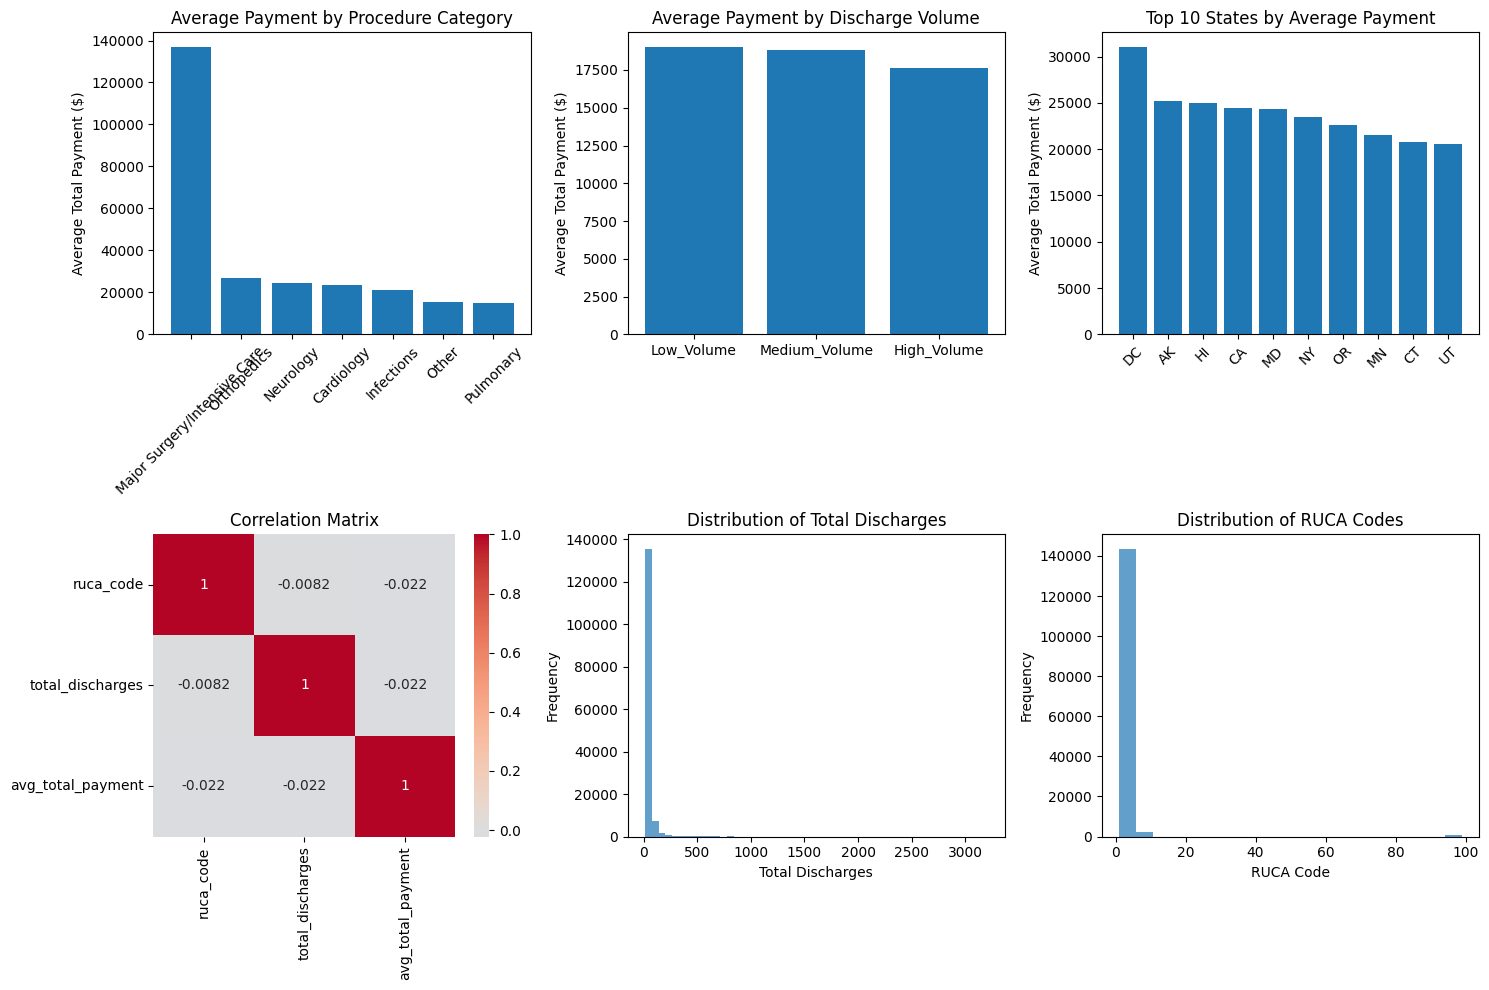

In [66]:
#=============================================================================
# 6. Data Visualization
# =============================================================================

plt.figure(figsize=(15, 10))

# 1. Average payment by procedure category
plt.subplot(2, 3, 1)
procedure_payments = df.groupby('procedure_category')['avg_total_payment'].mean().sort_values(ascending=False)
plt.bar(range(len(procedure_payments)), procedure_payments.values)
plt.xticks(range(len(procedure_payments)), procedure_payments.index, rotation=45)
plt.title('Average Payment by Procedure Category')
plt.ylabel('Average Total Payment ($)')

# 2. Average payment by discharge volume
plt.subplot(2, 3, 2)
volume_payments = df.groupby('discharge_volume')['avg_total_payment'].mean()
plt.bar(volume_payments.index, volume_payments.values)
plt.title('Average Payment by Discharge Volume')
plt.ylabel('Average Total Payment ($)')

# 3. Average payment by state (top 10)
plt.subplot(2, 3, 3)
state_payments = df.groupby('state_abbr')['avg_total_payment'].mean().sort_values(ascending=False).head(10)
plt.bar(range(len(state_payments)), state_payments.values)
plt.xticks(range(len(state_payments)), state_payments.index, rotation=45)
plt.title('Top 10 States by Average Payment')
plt.ylabel('Average Total Payment ($)')

# 4. Correlation heatmap
plt.subplot(2, 3, 4)
numeric_cols = ['ruca_code', 'total_discharges', 'avg_total_payment']
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')

# 5. Distribution of total discharges
plt.subplot(2, 3, 5)
plt.hist(df['total_discharges'], bins=50, alpha=0.7)
plt.title('Distribution of Total Discharges')
plt.xlabel('Total Discharges')
plt.ylabel('Frequency')

# 6. RUCA code distribution
plt.subplot(2, 3, 6)
plt.hist(df['ruca_code'], bins=20, alpha=0.7)
plt.title('Distribution of RUCA Codes')
plt.xlabel('RUCA Code')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [67]:
# =============================================================================
# 7. Data Preparation for Machine Learning
# =============================================================================

# Handle missing values
print("Missing values before handling:")
print(df.isnull().sum())

# Fill any remaining missing values
df = df.dropna()

print("Shape after dropping missing values:", df.shape)

# Prepare features for modeling
# One-hot encode categorical variables
categorical_columns = ['state_abbr', 'procedure_category', 'discharge_volume', 'state_procedure_interaction']

# Create a copy of the dataframe for encoding
df_encoded = df.copy()

# One-hot encode categorical variables
for col in categorical_columns:
    if col in df_encoded.columns:
        dummies = pd.get_dummies(df_encoded[col], prefix=col, drop_first=True)
        df_encoded = pd.concat([df_encoded, dummies], axis=1)
        df_encoded = df_encoded.drop(col, axis=1)

# Define features and target
X = df_encoded.drop(['avg_total_payment'], axis=1)
y = df_encoded['avg_total_payment']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Feature columns:")
print(X.columns.tolist())

Missing values before handling:
state_abbr                     0
ruca_code                      0
total_discharges               0
avg_total_payment              0
procedure_category             0
state_procedure_interaction    0
discharge_volume               0
dtype: int64
Shape after dropping missing values: (146427, 7)
Features shape: (146427, 411)
Target shape: (146427,)
Feature columns:
['ruca_code', 'total_discharges', 'state_abbr_AL', 'state_abbr_AR', 'state_abbr_AZ', 'state_abbr_CA', 'state_abbr_CO', 'state_abbr_CT', 'state_abbr_DC', 'state_abbr_DE', 'state_abbr_FL', 'state_abbr_GA', 'state_abbr_HI', 'state_abbr_IA', 'state_abbr_ID', 'state_abbr_IL', 'state_abbr_IN', 'state_abbr_KS', 'state_abbr_KY', 'state_abbr_LA', 'state_abbr_MA', 'state_abbr_MD', 'state_abbr_ME', 'state_abbr_MI', 'state_abbr_MN', 'state_abbr_MO', 'state_abbr_MS', 'state_abbr_MT', 'state_abbr_NC', 'state_abbr_ND', 'state_abbr_NE', 'state_abbr_NH', 'state_abbr_NJ', 'state_abbr_NM', 'state_abbr_NV', 'state_ab

In [68]:
# =============================================================================
# 8. Train-Test Split
# =============================================================================
# Apply log1p transformation to the target variable
y=np.log1p(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (117141, 411)
Test set shape: (29286, 411)


In [69]:
# =============================================================================
# 9. Model Training and Evaluation with Debugging
# =============================================================================

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a machine learning model with debugging info
    """
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")
    print(f"{'='*50}")

    # Debug: Check input data ranges
    print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Test set size: {X_test.shape[0]} samples")

    print(f"\nLog-transformed target statistics:")
    print(f"y_train - Min: {y_train.min():.4f}, Max: {y_train.max():.4f}, Mean: {y_train.mean():.4f}")
    print(f"y_test - Min: {y_test.min():.4f}, Max: {y_test.max():.4f}, Mean: {y_test.mean():.4f}")

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions (in log scale)
    y_pred_test = model.predict(X_test)

    print(f"\nPredictions in log scale:")
    print(f"y_pred_test - Min: {y_pred_test.min():.4f}, Max: {y_pred_test.max():.4f}, Mean: {y_pred_test.mean():.4f}")

    # Inverse log1p transformation
    y_pred_test_original = np.expm1(y_pred_test)
    y_test_original = np.expm1(y_test)

    print(f"\nAfter inverse transformation (original scale):")
    print(f"y_test_original - Min: ${y_test_original.min():,.2f}, Max: ${y_test_original.max():,.2f}, Mean: ${y_test_original.mean():,.2f}")
    print(f"y_pred_original - Min: ${y_pred_test_original.min():,.2f}, Max: ${y_pred_test_original.max():,.2f}, Mean: ${y_pred_test_original.mean():,.2f}")

    # Check for any extreme values
    if np.any(y_pred_test_original < 0):
        print(f"WARNING: Found {np.sum(y_pred_test_original < 0)} negative predictions after transformation!")
        y_pred_test_original = np.maximum(y_pred_test_original, 0)  # Clip negatives
        print("Negative predictions clipped to 0")

    # Calculate metrics
    test_mae = mean_absolute_error(y_test_original, y_pred_test_original)
    test_r2 = r2_score(y_test_original, y_pred_test_original)
    test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))

    # Calculate percentage error for context
    mape = np.mean(np.abs((y_test_original - y_pred_test_original) / y_test_original)) * 100

    print(f"\n{model_name} Results:")
    print(f"Test MAE: ${test_mae:,.2f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test RMSE: ${test_rmse:,.2f}")
    print(f"Test MAPE: {mape:.2f}%")

    # Show sample predictions vs actual
    print(f"\nSample Predictions vs Actual (first 10):")
    for i in range(min(10, len(y_test_original))):
        print(f"Actual: ${y_test_original.iloc[i]:,.2f}, Predicted: ${y_pred_test_original[i]:,.2f}, Diff: ${abs(y_test_original.iloc[i] - y_pred_test_original[i]):,.2f}")

    return {
        'model': model,
        'model_name': model_name,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mape': mape,
        'y_test_original': y_test_original,
        'y_pred_original': y_pred_test_original
    }

# Initialize models
models = {
    'LightGBM': LGBMRegressor(random_state=42, verbose=-1),
}

# Before training, let's also check the original data transformation
print("Data Verification:")
print(f"Original y shape: {y.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

# Check if log transformation makes sense
original_y_sample = np.expm1(y[:10])
print(f"\nSample of original target values (before log): ${original_y_sample}")
print(f"Sample of log-transformed values: {y[:10].values}")

# Train and evaluate all models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, X_test, y_train, y_test, name)

Data Verification:
Original y shape: (146427,)
y_train shape: (117141,), y_test shape: (29286,)

Sample of original target values (before log): $0    120219.93
1     37321.04
2     26936.67
3     34745.38
4     14999.82
5      8650.56
6      8522.47
7     14155.06
8      7746.41
9      6334.82
Name: avg_total_payment, dtype: float64
Sample of log-transformed values: [11.69708641 10.52733932 10.20128096 10.45583067  9.61586015  9.06549493
  9.05057881  9.55789808  8.95511387  8.75397452]

Training LightGBM...
Training set size: 117141 samples, 411 features
Test set size: 29286 samples

Log-transformed target statistics:
y_train - Min: 7.5701, Max: 13.3850, Mean: 9.5601
y_test - Min: 7.9535, Max: 13.5434, Mean: 9.5635

Predictions in log scale:
y_pred_test - Min: 8.8205, Max: 11.9102, Mean: 9.5586

After inverse transformation (original scale):
y_test_original - Min: $2,844.48, Max: $761,738.78, Mean: $18,710.90
y_pred_original - Min: $6,770.56, Max: $148,770.43, Mean: $15,112.02

LightG


Model Comparison (sorted by Test R²):
      Model     Test_MAE  Test_R2     Test_RMSE
0  LightGBM  8914.054853  0.24979  19511.406317


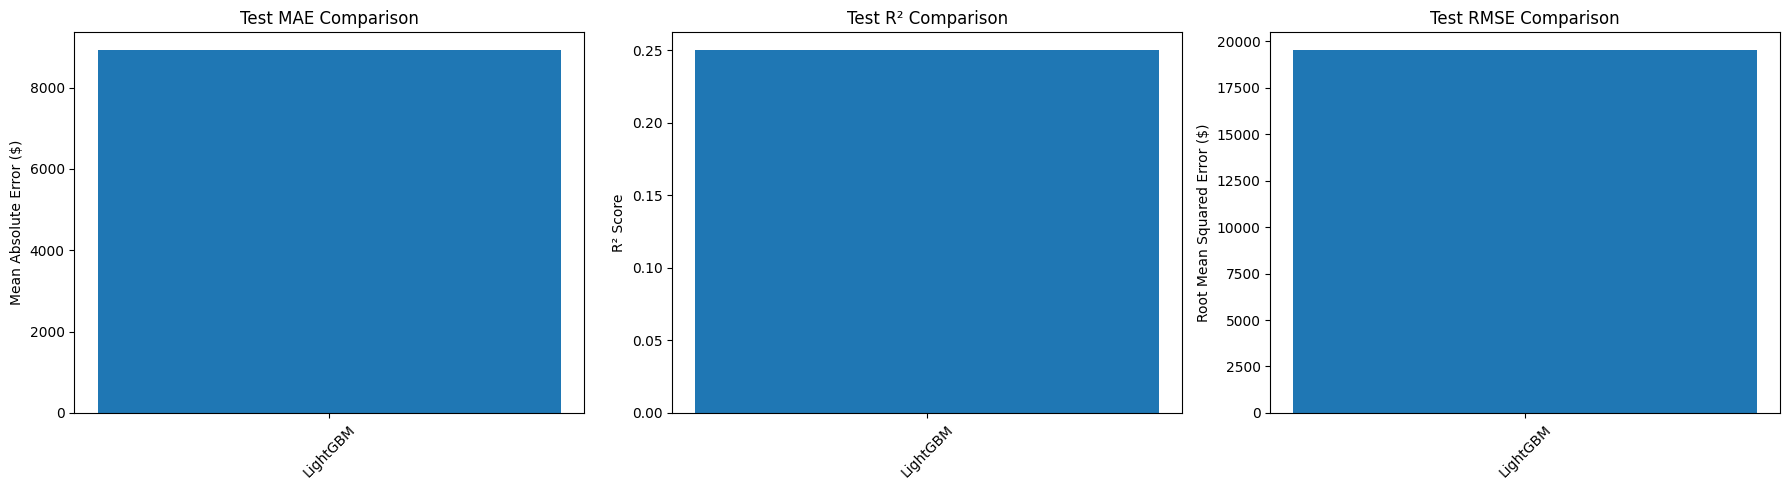

In [70]:
# =============================================================================
# 10. Model Comparison and Visualization
# =============================================================================

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test_MAE': [results[model]['test_mae'] for model in results.keys()],
    'Test_R2': [results[model]['test_r2'] for model in results.keys()],
    'Test_RMSE': [results[model]['test_rmse'] for model in results.keys()]
})

# Sort by Test R²
comparison_df = comparison_df.sort_values('Test_R2', ascending=False)
print("\nModel Comparison (sorted by Test R²):")
print(comparison_df)

# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Test MAE comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test_MAE'])
axes[0].set_title('Test MAE Comparison')
axes[0].set_ylabel('Mean Absolute Error ($)')
axes[0].tick_params(axis='x', rotation=45)

# Test R² comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test_R2'])
axes[1].set_title('Test R² Comparison')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)

# Test RMSE comparison
axes[2].bar(comparison_df['Model'], comparison_df['Test_RMSE'])
axes[2].set_title('Test RMSE Comparison')
axes[2].set_ylabel('Root Mean Squared Error ($)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [71]:
# =============================================================================
# 11. Hyperparameter Tuning for Best Model
# =============================================================================

# Get the best performing model
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest performing model: {best_model_name}")

# Hyperparameter tuning for LightGBM (typically performs well)
if 'LightGBM' in results:
    print("\nPerforming hyperparameter tuning for LightGBM...")

    # Define parameter grid
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, -1],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
        'min_child_samples': [10, 20, 30]
    }

    # Randomized search
    lgbm = LGBMRegressor(random_state=42, verbose=-1)
    random_search = RandomizedSearchCV(
        lgbm, param_grid, n_iter=20, cv=3,
        scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1
    )

    random_search.fit(X_train, y_train)

    print("Best parameters:", random_search.best_params_)
    print("Best cross-validation score:", -random_search.best_score_)

    # Evaluate tuned model
    tuned_results = evaluate_model(
        random_search.best_estimator_, X_train, X_test, y_train, y_test,
        'LightGBM (Tuned)'
    )



Best performing model: LightGBM

Performing hyperparameter tuning for LightGBM...
Best parameters: {'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 30, 'max_depth': 7, 'learning_rate': 0.1}
Best cross-validation score: 0.45682484625688063

Training LightGBM (Tuned)...
Training set size: 117141 samples, 411 features
Test set size: 29286 samples

Log-transformed target statistics:
y_train - Min: 7.5701, Max: 13.3850, Mean: 9.5601
y_test - Min: 7.9535, Max: 13.5434, Mean: 9.5635

Predictions in log scale:
y_pred_test - Min: 8.7339, Max: 11.9741, Mean: 9.5585

After inverse transformation (original scale):
y_test_original - Min: $2,844.48, Max: $761,738.78, Mean: $18,710.90
y_pred_original - Min: $6,209.13, Max: $158,597.58, Mean: $15,148.92

LightGBM (Tuned) Results:
Test MAE: $8,907.27
Test R²: 0.2519
Test RMSE: $19,483.30
Test MAPE: 47.12%

Sample Predictions vs Actual (first 10):
Actual: $9,919.64, Predicted: $11,121.79, Diff: $1,202.15
Actual: $4,852.67, Predicted: $12,08


Top 15 Feature Importances - LightGBM:
                                            feature  importance
1                                  total_discharges         886
0                                         ruca_code         266
56                         procedure_category_Other         101
5                                     state_abbr_CA          82
21                                    state_abbr_MD          70
52                    procedure_category_Infections          69
35                                    state_abbr_NY          66
54                     procedure_category_Neurology          53
10                                    state_abbr_FL          47
8                                     state_abbr_DC          39
53  procedure_category_Major Surgery/Intensive Care          39
57                     procedure_category_Pulmonary          36
55                   procedure_category_Orthopedics          35
16                                    state_abbr_IN          34


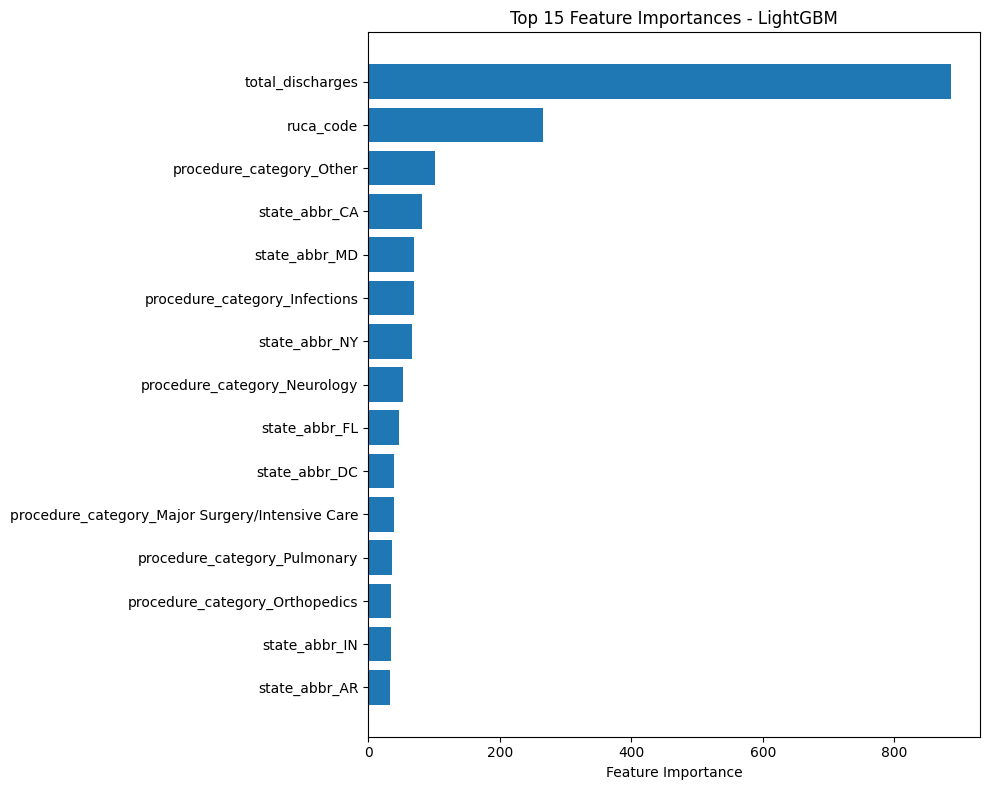

In [72]:
# =============================================================================
# 12. Feature Importance Analysis
# =============================================================================

# Get feature importance from the best tree-based model
best_tree_models = ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']
for model_name in best_tree_models:
    if model_name in results:
        model = results[model_name]['model']
        if hasattr(model, 'feature_importances_'):
            # Get feature importance
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)

            print(f"\nTop 15 Feature Importances - {model_name}:")
            print(feature_importance.head(15))

            # Plot feature importance
            plt.figure(figsize=(10, 8))
            top_features = feature_importance.head(15)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title(f'Top 15 Feature Importances - {model_name}')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.show()
            break


Prediction Examples (First 10 test samples):
     Actual     Predicted   Difference  Absolute_Error
0   9919.64  13452.660253 -3533.020253     3533.020253
1   4852.67  13961.560462 -9108.890462     9108.890462
2  23289.47  15932.223301  7357.246699     7357.246699
3  27872.92  23536.034418  4336.885582     4336.885582
4   9541.61  15437.616191 -5896.006191     5896.006191
5   8371.66  15135.715151 -6764.055151     6764.055151
6   6549.45  11350.456546 -4801.006546     4801.006546
7  22235.19  13903.922947  8331.267053     8331.267053
8  22891.71  21553.306252  1338.403748     1338.403748
9   6714.73  11634.590126 -4919.860126     4919.860126


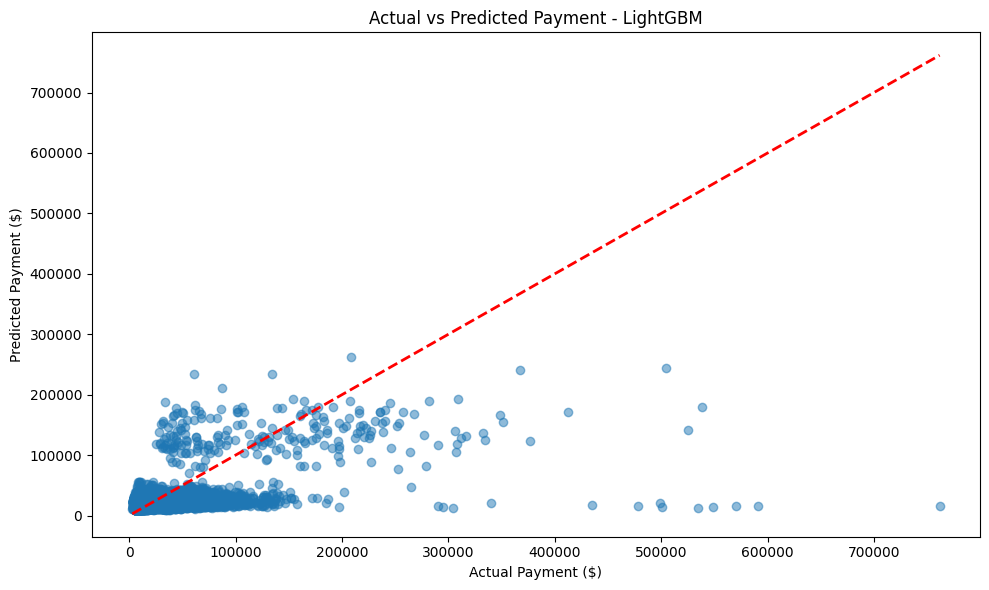

In [15]:
#=============================================================================
# 13. Prediction Examples
# =============================================================================

# Make predictions on test set with best model
best_model = results[best_model_name]['model']
y_pred = best_model.predict(X_test)

# Show some prediction examples
prediction_examples = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10],
    'Difference': y_test.values[:10] - y_pred[:10]
})
prediction_examples['Absolute_Error'] = np.abs(prediction_examples['Difference'])

print("\nPrediction Examples (First 10 test samples):")
print(prediction_examples)

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Payment ($)')
plt.ylabel('Predicted Payment ($)')
plt.title(f'Actual vs Predicted Payment - {best_model_name}')
plt.tight_layout()
plt.show()

In [73]:
# =============================================================================
# 14. Summary and Insights
# =============================================================================

print("\n" + "="*60)
print("MEDICARE HEALTHCARE COST PREDICTION ANALYSIS SUMMARY")
print("="*60)

print(f"\nDataset Information:")
print(f"- Total records processed: {len(df):,}")
print(f"- Features used: {X.shape[1]}")
print(f"- Target variable: Average Total Payment")

print(f"\nBest Performing Model: {best_model_name}")
print(f"- Test R² Score: {results[best_model_name]['test_r2']:.4f}")
print(f"- Test MAE: ${results[best_model_name]['test_mae']:,.2f}")
print(f"- Test RMSE: ${results[best_model_name]['test_rmse']:,.2f}")

print(f"\nKey Insights:")
print("1. Procedure category is likely a major predictor of healthcare costs")
print("2. Geographic location (state) influences payment amounts")
print("3. Hospital discharge volume affects cost patterns")
print("4. RUCA codes (rural-urban classification) impact healthcare costs")

print(f"\nModel Performance Ranking:")
for i, (_, row) in enumerate(comparison_df.iterrows(), 1):
    print(f"{i}. {row['Model']} - R²: {row['Test_R2']:.4f}, MAE: ${row['Test_MAE']:,.2f}")

print("\n" + "="*60)
print("Analysis completed successfully!")
print("="*60)


MEDICARE HEALTHCARE COST PREDICTION ANALYSIS SUMMARY

Dataset Information:
- Total records processed: 146,427
- Features used: 411
- Target variable: Average Total Payment

Best Performing Model: LightGBM
- Test R² Score: 0.2498
- Test MAE: $8,914.05
- Test RMSE: $19,511.41

Key Insights:
1. Procedure category is likely a major predictor of healthcare costs
2. Geographic location (state) influences payment amounts
3. Hospital discharge volume affects cost patterns
4. RUCA codes (rural-urban classification) impact healthcare costs

Model Performance Ranking:
1. LightGBM - R²: 0.2498, MAE: $8,914.05

Analysis completed successfully!
